In [44]:
import numpy as np
import h5py
import tifffile
import scipy as sp
import scipy.spatial as sptl
import scipy.sparse as sprs
from skimage.measure import regionprops, regionprops_table
from skimage.draw import line_nd
from skimage.morphology import ball
import matplotlib.pyplot as plt
from tqdm import tqdm
import nrrd
import pandas as pd
import seaborn as sns

In [13]:
marker_names = ["DNA1","PD1","TLR3","SOX10","DNA2","CD163",
"CD3D","PDL1","DNA3","CD4","ICOS","HLADPB1","DNA4","CD8A",
"CD68","GZMB","DNA5","CD40L","LAG3","HLAA","DNA6","SQSTM",
"VIN","TIM3","DNA7","LAMP1_CD107A","PDL1_2","PD1_2", "DNA_masks", 
"HLAA_masks", "DNA_binary_masks", "HLAA_binary_masks"]

In [26]:
def generate_cube(filename):
    img = tifffile.imread(filename)
    img = np.moveaxis(img, 0, 1)
    with h5py.File("data/cube.h5", "w") as cube:
        for i, c in enumerate(marker_names):
            cube.create_dataset(c, data=img[i])

def load_channel(channel_name=None):
    with h5py.File("data/cube.h5", "r") as cubef:
        if channel_name != None:
            return np.array(cubef[channel_name])
        return cubef

def load_cube(channel_names):
    with h5py.File("data/cube.h5", "r") as cubef:
        cube = [np.array(cubef[c]) for c in channel_names]
        cube = np.stack(cube)
        return cube

def get_nuclei_centers(channel):
    regions = regionprops(channel)
    centers = [region.centroid for region in regions]
    return np.array(centers, dtype=int)

def get_delaunay_edges(points):
    tri = sptl.Delaunay(points)
    lil = sprs.lil_matrix((tri.npoints, tri.npoints))

    indices, indptr = tri.vertex_neighbor_vertices
    for k in range(tri.npoints):
        lil.rows[k] = indptr[indices[k]:indices[k+1]].tolist()
        lil.data[k] = np.ones_like(lil.rows[k]).tolist()

    coo = lil.tocoo()
    conns = np.vstack((coo.row, coo.col)).T
    delaunay_conns = np.sort(conns, axis=1)
    return delaunay_conns, tri

def get_gabriel_graph(tri, delaunay_conns):
    c = tri.points[delaunay_conns]
    m = (c[:, 0, :] + c[:, 1, :])/2
    r = np.sqrt(np.sum((c[:, 0, :] - c[:, 1, :])**2, axis=1))/2


    tree = sptl.cKDTree(points)
    n = tree.query(x=m, k=1)[0]
    g = n >= r*(0.999)
    gabriel_conns = delaunay_conns[g]
    edges = []
    for edge in gabriel_conns:
        found = False
        for controll in edges:
            if controll[0] == edge[0] and controll[1] == edge[1]:
                found = True
                break
        if not found:
            edges.append(edge)
    return edges

def generate_visual_edges(gabriel_conns, shape, radius):
    visual_graph = np.zeros(shape, dtype=np.uint16)
    for i, gabriel_con in tqdm(enumerate(gabriel_conns), total=len(gabriel_conns)):
        start = points[gabriel_con[0]]
        end = points[gabriel_con[1]]
        edge = line_nd(start, end)
        edge = np.transpose(edge)
        for point in edge:
            visual_graph[point[0], point[1], point[2]] = i
            new_points = thicken_line(point, radius)
            for new_point in new_points:
                visual_graph[point[0], point[1], point[2]] = i
                
    visual_graph = np.expand_dims(visual_graph, 0)
    return visual_graph

def thicken_line(point, radius):
    point = np.array(point)
    sphere = np.transpose(np.nonzero(ball(radius)))
    for coord in sphere:
        for dim in range(len(point)):
            coord[dim] += (point[dim]-radius)
    sphere = np.where(sphere > 0, sphere, 0)
    return sphere

def save_graph(verteces, edges, filename):
    with h5py.File(filename, "w") as f:
        f.create_dataset("verteces", data=verteces)
        f.create_dataset("edges", data=edges)

def generate_nrrds(channels):
    for channel_name in tqdm(channels):
        marker = load_channel(channel_name)
        marker = np.array(marker, dtype=np.float32)
        marker = np.moveaxis(marker, 0, -1)
        marker = np.moveaxis(marker, 0, 1)
        marker /= np.max(marker)
        marker *= 255
        marker = marker.astype(np.uint8)
        nrrd.write("data/{}.nrrd".format(channel_name), marker)

def meassure_markers(marker_names, edge_channel):
    with h5py.File("data/graph.h5", "a") as graph:
        edge_channel = np.squeeze(edge_channel)
        meansds = graph.create_group("means")
        for marker_name in tqdm(marker_names):
            means = []
            marker = load_channel(marker_name)
            marker = np.array(marker, dtype=np.float32)
            marker /= np.max(marker)
            for edge in np.unique(edge_channel):
                edge_coords = np.where(edge_channel == edge)
                means.append(np.mean(marker[edge_coords]))
            meansds.create_dataset(marker_name, data=means)

In [27]:
filename = 'data/20_R3D_D3D_3D_MERGED.tif'
targetname = 'data/20_graph.tif'
generate_cube(filename)
dna_masks = load_channel("DNA_masks")
points = get_nuclei_centers(dna_masks)
delaunay_conns, tri = get_delaunay_edges(points)
gabriel_conns = get_gabriel_graph(tri, delaunay_conns)
save_graph(points, gabriel_conns, "data/graph.h5")
#generate_nrrds(marker_names)
#edge_channel = generate_visual_edges(gabriel_conns, dna_masks.shape, 8)
#cube = load_cube(marker_names)
#cube = np.append(cube, edge_channel, axis=0)
#cube = np.moveaxis(cube, 0, 1)
#tifffile.imwrite(targetname, cube, imagej=True)

In [29]:
with h5py.File("data/graph.h5", "r") as f:
    edges = f['edges']
    print(len(edges))

902


In [23]:
filename = 'data/20_R3D_D3D_3D_MERGED.tif'
generate_cube(filename)
dna_masks = load_channel("DNA_masks")
points = get_nuclei_centers(dna_masks)
delaunay_conns, tri = get_delaunay_edges(points)
gabriel_conns = get_gabriel_graph(tri, delaunay_conns)
edge_channel = generate_visual_edges(gabriel_conns, dna_masks.shape, 4)
print(len(np.unique(edge_channel)))

100%|██████████| 1804/1804 [00:27<00:00, 64.77it/s] 


902


In [42]:
dna_masks = load_channel("DNA_masks")
props = regionprops_table(dna_masks, properties=('area',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
df = pd.DataFrame(props)

<AxesSubplot:xlabel='area', ylabel='Count'>

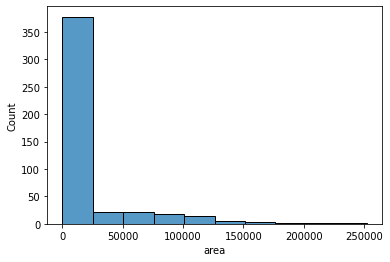

In [47]:
sns.histplot(df['area'], bins=10)